# Experiments with multiple robots

Illustrating various ways of running a __one day__ experiment on a __static environment__ with a __multiple robots__. The experiments compare estimator/path planner pairs. The path planners are simple static examples (lawnmower, spiral, random waypoint) and they are not intended to be state of the art

In [ ]:
import sys

sys.path.append('..')
from settings import Config
import logging
logging.basicConfig(level=logging.WARNING)

import pathlib
import socket
import pickle
import gzip as compress
import copy
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
# configuring the fonts such that no Type 3 fonts are used
# requirement for ICRA
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["figure.autolayout"] = True

import numpy as np
import timeit
import warnings

from InformationModel import StoredObservationIM
from WaterberryFarm import create_wbfe, WaterberryFarm, MiniberryFarm, WBF_IM_DiskEstimator, WBF_IM_GaussianProcess, WBF_Score_WeightedAsymmetric, get_datadir
from WbfExperiment import action_run_1day, action_precompute_environment, get_geometry
from WbfExperimentMultiRobot import action_run_1day_multirobot
from WbfFigures import graph_env_im, graph_scores, hook_create_pictures, end_of_day_graphs, add_robot_path
from Policy import FollowPathPolicy, RandomWaypointPolicy
from PathGenerators import find_fixed_budget_spiral, generate_lawnmower, find_fixed_budget_lawnmower, generate_spiral_path, find_fixed_budget_spiral

logging.getLogger().setLevel(logging.WARNING)

# all the experiments results etc. should go into this directory
benchmark_dir = pathlib.Path(get_datadir(), "MultiRobotExperiments")
benchmark_dir.mkdir(exist_ok=True)

In [3]:
default_choices = {"geometry": "Miniberry-100", "action": "run", "scenario": "one-day-single-value", "visualize": 0,  "results-basedir": benchmark_dir}
default_choices["velocity"] = 1
default_choices["timesteps-per-day-override"] = 500 # 1000
default_choices["time-start-environment"] = 6
# uncomment or change this to a lower number to run the estimator more often
default_choices["im_resolution"] = 10
# uncomment this to generate pictures. WARNING: takes longer!
# default_choices["hook-after-day"] = hook_create_pictures

# precompute environments for a very little time, as these are static
precompute = 7
typenames = ["Miniberry-100"]
time_start_environment = 6

for typename in typenames:
    action_precompute_environment({"geometry": typename, "precompute-time": precompute})

## Run one experiment with two random policies

This is a starting experiment if we can successfully run an experiment with two robots 

In [4]:
geo = get_geometry(default_choices["geometry"])
policy1 = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)
policy2 = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 1)
policies = [policy1, policy2]
policy_names = ["poli1", "poly2"]

choices = copy.copy(default_choices)
choices["results-filename"] = "two-random"
choices["policy-code"] = policies
choices["dryrun"] = False
choices["estimator-name"] = "AD"
choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
choices["score-code"] = WBF_Score_WeightedAsymmetric()

# choices["hook-after-day"] = hook_create_pictures

results = action_run_1day_multirobot(choices)
path = results["results-path"]
print(path)

C:\Users\lboloni\Documents\Code\_TempData\WBF\MultiRobotExperiments\two-random


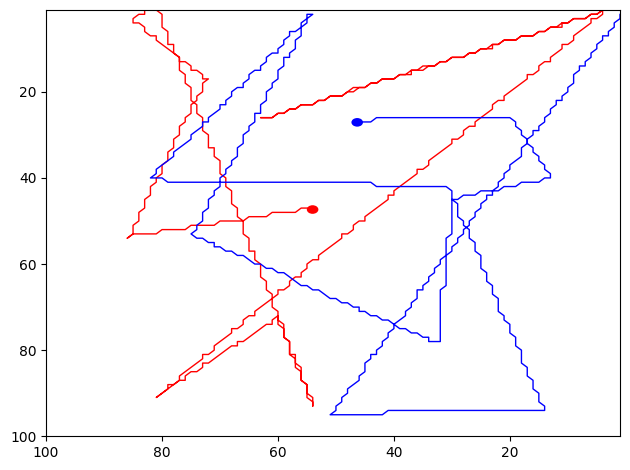

In [5]:
# visualize the paths
fig, ax = plt.subplots(1,1)
ax.set_xlim(100)
ax.set_ylim(100)
add_robot_path(results, ax, draw_robot=True)


## Configurations of multiple robots with multiple policies

* Create three experiments with two robots each.
    * Two random policies (Rand-Rand)
    * One random policy + one FBLM (Rand-FBLM)
    * Two FBLM (FBLM-FBLM)
* Run the three experiments
* Plot the evolution of the scores in time
* Create the general picture for them

In [6]:
def configurations_with_two_robots(geom):
    policies = []

    # Rand-Rand
    policy_set = []
    geo = copy.copy(geom)
    policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  
    policy.name = "RandomWaypoint-Seed0"
    policy_set.append(policy)

    geo = copy.copy(geom)
    policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 1)  
    policy.name = "RandomWaypoint-Seed1"
    policy_set.append(policy)

    policies.append({"name": "rand-rand", "policies": policy_set})

    # Rand-FBLM
    policy_set = []
    geo = copy.copy(geom)
    policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  
    policy.name = "RandomWaypoint-Seed0"
    policy_set.append(policy)

    geo = copy.copy(geom)
    path = find_fixed_budget_lawnmower([0,0], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"], geo["velocity"], time = geo["timesteps-per-day"])
    policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
    policy.name = "FixedBudgetLawnmower"
    policy_set.append(policy)

    policies.append({"name": "rand-fblm", "policies": policy_set})

    # FBLM-FBLM
    policy_set = []

    geo = copy.copy(geom)
    path = find_fixed_budget_lawnmower([0,0], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"], geo["velocity"], time = geo["timesteps-per-day"])
    policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
    policy.name = "FixedBudgetLawnmower"
    policy_set.append(policy)

    geo = copy.copy(geom)
    path = find_fixed_budget_lawnmower([0,0], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"], geo["velocity"], time = geo["timesteps-per-day"])
    policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
    policy.name = "FixedBudgetLawnmower"
    policy_set.append(policy)

    policies.append({"name": "fblm-fblm", "policies": policy_set})

    return policies


In [7]:
def run_multi_policies(policies, default_choices, force_run = False):
    """Run scenarios with multiple robots, with different policies.
    The policies should be a list with one dictionary / item with the fields
    name and policies. The policies is a vector of policies, one for each robot.
    """
    picture_paths = []

    for p in policies:
        # do a dryrun, to get the path to the cached values
        choices = copy.copy(default_choices)
        choices["policy-code"] = p["policies"]
        # FIXME: technically, this is the experiment name, used both 
        # for file name as well as in visualization.
        # make sure it works
        choices["file-name"] = p["name"]
        choices["dryrun"] = True
        results = action_run_1day_multirobot(choices)
        path = results["results-path"]
        print(path)
        # print(results.keys())
        # avoid re-running experiments
        if not path.exists() or force_run:
            print(f"{p['name']}: Running the experiments")
            choices["dryrun"] = False
            results = action_run_1day(choices)
        else:
            print(f"{p['name']}: Reusing previously done experiment results")
            with compress.open(path, "rb") as f:
                results = pickle.load(f)
        # FIXME: I think that this was used for videos, but this is 
        # not a clean way to do this.
        if "picture-path" in results:
            print("Picture path in results!")
            picture_paths.append(results["picture-path"])
        # FIXME: probably this whole experiment setting should have a name
        # and that is what we want to have in there.
        end_of_day_graphs(results, f"daily-summary-{results['policy-code'].name}-{results['estimator-name']}.pdf", plot_uncertainty = False)

In [8]:
geo = get_geometry(default_choices["geometry"])
policies = configurations_with_two_robots(geo)
run_multi_policies(policies, default_choices, force_run = False)

C:\Users\lboloni\Documents\Code\_TempData\WBF\MultiRobotExperiments\res_Miniberry-100_1M__RandomWaypoint-Seed0_RandomWaypoint-Seed1
rand-rand: Running the experiments


AttributeError: 'list' object has no attribute 'name'

## Configurations with different numbers of robots
* Create experiments with 1, 2, ...5 robots with Random Waypoint policies
* Run the experiments 
* Plot the evolution of the scores in time
* Create the general picture for them


In [9]:
def configurations_with_variable_no_robots(geom):
    policies = []

    for i in range(1, 5):
        policy_set = []
        geo = copy.copy(geom)
        for j in range(0, i):
            policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = j)  
            policy.name = "RandomWaypoint-Seed0"
            policy_set.append(policy)
        policies.append({"name": f"rand-{i}", "policies": policy_set})

    return policies


In [ ]:
geo = get_geometry(default_choices["geometry"])
policies = configurations_with_variable_no_robots(geo)
run_multi_policies(policies, default_choices, force_run = False)